In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse, optimize
import numba as nb
import numba.experimental as nbe
import sympy as sp
import pandas as pd

config = {'figure.figsize':(14,4),
          'figure.dpi':77,
          'axes.grid':True,
          'grid.linestyle':'--',
          'grid.linewidth':0.5,
          'axes.spines.top':False,
          'axes.spines.bottom':False,
          'axes.spines.left':False,
          'axes.spines.right':False}

plt.rcParams.update(config)

from gEconpy.classes.time_aware_symbol import TimeAwareSymbol
from gEconpy.shared.utilities import eq_to_ss

# Learning Goals

The objective of this notebook is to explore so-called "Perfect Foresight" solutions to non-linear models. There are two solution algorithms used for this purpose: "shooting" and "relaxation". Quantecon has a really nice lecture on shooting here, which I'll begin with. Then I'll turn to relaxation, following the lecture notes of Stéphane Adjemain from here. 

For the first pass, I'll look at solving for trajectories of a single state and single control, using the following model: 

## The Basic Model

In [83]:
C, K, A = [TimeAwareSymbol(x, 0) for x in ['C', 'K', 'A']]
alpha, beta, delta, rho = sp.symbols('alpha beta delta rho')

param_dict = {'alpha':0.33, 'beta':0.99, 'delta':0.035}

euler = C.step_forward() / C - beta * (alpha * sp.exp(A.step_forward()) * K.step_forward() ** (alpha - 1) + 1 - delta)
transition = K.step_forward() - (sp.exp(A) * K ** alpha + (1 - delta) * K - C)
shock = A - rho * A.step_backward()

system = [euler, transition, shock]
for eq in system:
    display(eq)

-beta*(alpha*K_t+1**(alpha - 1)*exp(A_t+1) - delta + 1) + C_t+1/C_t

C_t - K_t*(1 - delta) - K_t**alpha*exp(A_t) + K_t+1

-rho*A_t-1 + A_t

Actually the model will be even simpler than this, because shocks are set to zero. So the real system I'm looking at is:

In [3]:
det_system = [eq.subs({A:0, A.set_t(1):0, A.set_t(-1):0}) for eq in system if eq.subs({A:0, A.set_t(1):0, A.set_t(-1):0}) != 0]
for eq in det_system:
    display(eq)

-beta*(alpha*K_t+1**(alpha - 1) - delta + 1) + C_t+1/C_t

C_t - K_t*(1 - delta) - K_t**alpha + K_t+1

### Transition Dynamics
It's trivial to re-arrange these for transition equations in parameters and current state only, but I'll still have Sympy do it for me ;)

In [4]:
step_eqs = sp.solve(det_system, [C.set_t(1), K.set_t(1)], dict=True)[0]
for var, eq in step_eqs.items():
    display(sp.Eq(var, eq))
f_transition = sp.lambdify([K, C, alpha, beta, delta], list(step_eqs.values()))


Eq(C_t+1, beta*C_t*(alpha*(-delta*K_t - C_t + K_t + K_t**alpha)**(alpha - 1) - delta + 1))

Eq(K_t+1, -delta*K_t - C_t + K_t + K_t**alpha)

Using these equations we can generate trajectories from the model, given initial conditions. Here's a function that takes a system transition function, initial states, and deep parameters, and returns a trajectory:

In [5]:
def simulate_model(f, init_state_dict, param_dict, T=100):
    k = len(init_state_dict)
    simulation = np.full((T, k), np.nan)
    simulation[0] = list(init_state_dict.values())
    state_dict = init_state_dict.copy()
    states = list(state_dict.keys())
    for t in range(1, T):
        with np.errstate(divide='ignore', invalid='ignore'):
            state_dict = dict(zip(states, f(**(state_dict | param_dict))))
        if np.any(np.iscomplex(list(state_dict.values()))):
            break
        simulation[t] = list(state_dict.values())
        
    return pd.DataFrame(simulation, columns=[x.replace('_t', '') for x in states])

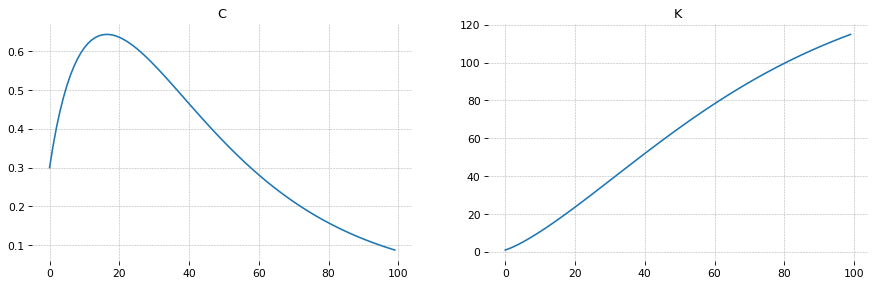

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
data = simulate_model(f_transition, {'C_t':0.3, 'K_t':1}, param_dict)
for axis, var in zip(fig.axes, data.columns):
    data[var].plot(ax=axis, title=var)

### Steady State
The reduced system has the following steady state:

In [7]:
ss_system = [eq_to_ss(eq).simplify() for eq in det_system]
ss_dict = sp.solve(ss_system, [K.to_ss(), C.to_ss()], dict=True)[0]

for var, eq in ss_dict.items():
    display(sp.Eq(var, eq))

Eq(C_ss, -delta*((beta*(delta - 1) + 1)/(alpha*beta))**(1/(alpha - 1)) + (((beta*(delta - 1) + 1)/(alpha*beta))**(1/(alpha - 1)))**alpha)

Eq(K_ss, ((beta*(delta - 1) + 1)/(alpha*beta))**(1/(alpha - 1)))

In [8]:
f_ss = sp.lambdify([alpha, beta, delta], list(ss_dict.values()))

Here I plot the example trajectory along with the steady state values. We can see that there is no guarantee that the system will go to the steady state from any initial conditions. In this case, initial consumption is too low, so it peters off towards zero, while capital accumulates divergently.

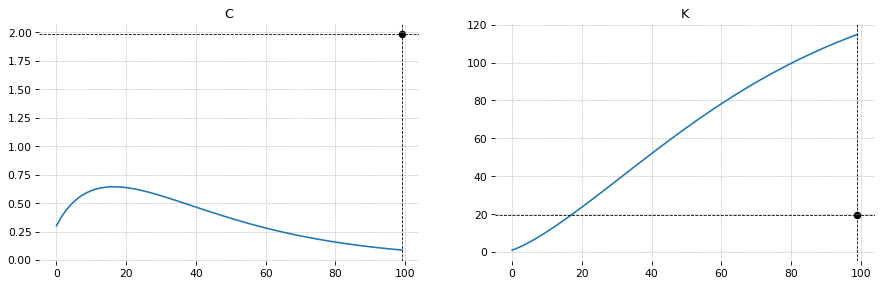

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))
data = simulate_model(f_transition, {'C_t':0.3, 'K_t':1}, param_dict)
ss_value_dict = dict(zip(data, f_ss(**param_dict)))
for axis, var in zip(fig.axes, data.columns):
    data[var].plot(ax=axis, title=var)
    axis.axvline(data.index[-1], ls='--', lw=0.75, c='k')
    axis.axhline(ss_value_dict[var], ls='--', lw=0.75, c='k')
    axis.scatter(data.index[-1], ss_value_dict[var], color='k')
    

### Phase Diagram

Indeed, we can summarize all the transitions of the system using a phase diagram. For this, we're interested in the rate of change for $K_{t+1}$ and $C_{t+1}$, i.e:

$$\Delta K_{t+1} = K_{t+1} - K_t, \Delta C_{t+1} = C_{t+1} - C_t$$

From our two system equations, we can compute:

$$ \Delta C_{t+1} = \left ( \beta \alpha K_{t+1}^{\alpha - 1} + \beta(1 - \delta) - 1 \right ) C_t$$ 

It's interesting to know when these deltas are exactly zero, as these will form boundaries in transition space. We'll plot with $k$ as the dependent variable, so we want to solve each in terms of $k$, giving:

$$\begin{align} C_t &= K_t^\alpha - \delta K_t \\ 
                C_t &= K_t ^ \alpha + (1 - \delta) K_t - K_{ss} \end{align}$$

Where $K_{ss}$ is the steady-state value of $K_t$. $\Delta K_{t+1}$ will be greater than zero when the first equation is positive, and $\Delta C_{t+1}$ will be greater than zero when the second equation is positive.

In [10]:
def plot_RBC_phase_diagram(k_max, param_dict, title=None, fig_ax = None, grid_size = 100, add_cbar=True, color_using='K'):
    assert color_using in ['C', 'K']
    c_max = k_max ** param_dict['alpha']
    k_grid = np.linspace(0, k_max, grid_size)
    c_grid = np.linspace(0, c_max, grid_size)

    kk, cc = np.meshgrid(k_grid, c_grid)

    def vectorized_step(K, C, params):
        alpha, beta, delta = params
        with np.errstate(divide='ignore', invalid='ignore'):
            return -delta*K - C + K + K**alpha, beta*C*(alpha*(-delta*K - C + K + K**alpha)**(alpha - 1) - delta + 1)

    kk_next, cc_next = vectorized_step(kk, cc, list(param_dict.values()))
    k_delta, c_delta = kk_next - kk, cc_next - cc
    
    if fig_ax is None:
        fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
    else:
        fig, ax = fig_ax
        
    ax.plot(k_grid, k_grid ** param_dict['alpha'] - param_dict['delta'] * k_grid, label='ΔK = 0')
    ax.plot(k_grid, k_grid ** param_dict['alpha'] + (1 - param_dict['delta']) * k_grid - f_ss(**param_dict)[1], label='ΔC = 0')

    quiver_plot = ax.quiver(kk, cc, k_delta, c_delta, k_delta if color_using == 'K' else c_delta, cmap=plt.cm.RdBu, clim=(-0.05, 0.05))
    
    title = title if title is not None else 'Phase Plot for Deterministic RBC'
    ax.set(xlim=(0, k_max), ylim=(0, c_max), xlabel='$K_t$', ylabel='$C_t$', title=title)
    
    if add_cbar:
        fig.colorbar(quiver_plot, shrink=0.8, label=f'Intensity of Δ{color_using}')
    ax.legend(loc='upper right')
    
    return (fig, ax)

def plot_simulation_in_phase_space(f, trajectory_start, param_dict, trajectory_steps=100, fig_ax=None):
    if fig_ax is None:
        fig, ax = plt.subplots()
    else:
        fig, ax = fig_ax
        
    traj = simulate_model(f_transition, trajectory_start, param_dict, T=trajectory_steps)
    for t in range(trajectory_steps):
        if t == 0:
            ax.scatter(traj.loc[0, 'K'], traj.loc[0, 'C'], marker='*', s=100, c='tab:orange', edgecolor='k', zorder=100)
            ax.annotate(text='Start', xy=traj.loc[0, ['K', 'C']].values * 1.01, zorder=105)
        else:
            x_start = traj.loc[t, ['K', 'C']].values
            x_stop = traj.loc[t-1, ['K', 'C']]

            if np.all(np.isreal([x_start, x_stop])):
                ax.annotate(text='', xy=x_start, xytext=x_stop, arrowprops={'arrowstyle':'->'})
    return (fig, ax)

We can see that $K_t$ is increasing below the blue curve and decreasing above it. The same is true for $C_t$ to the left and right of the orange line. This is most obvious at the very boundary, where $C_t$ is obviously increasing very quickly to the left of the line. To the right it is decreasing.

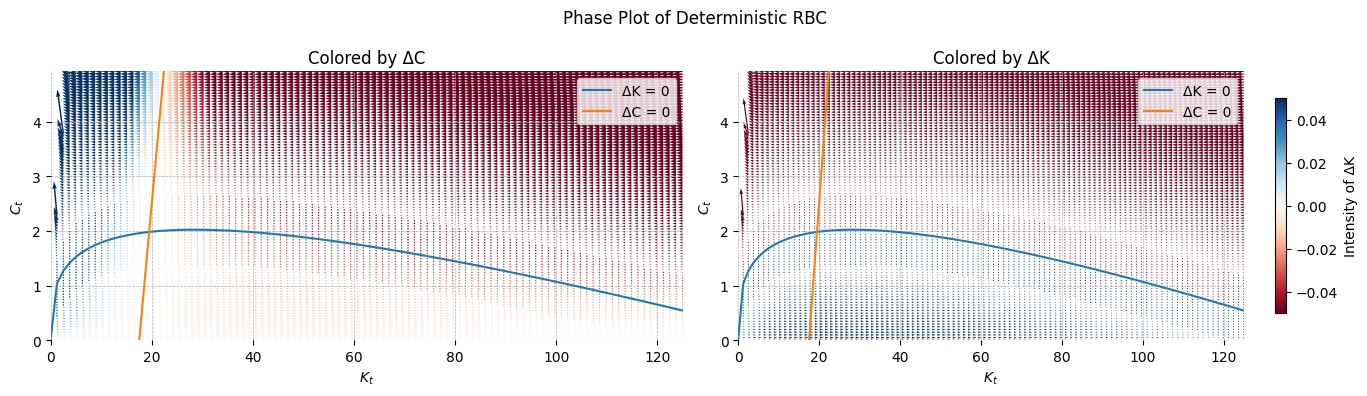

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4), dpi=100)
plot_RBC_phase_diagram(125, param_dict, title='Colored by ΔC', color_using='C', fig_ax = (fig, ax[0]), add_cbar=False)
plot_RBC_phase_diagram(125, param_dict, title='Colored by ΔK', color_using='K', fig_ax = (fig, ax[1]))
fig.suptitle('Phase Plot of Deterministic RBC')
fig.tight_layout()
plt.show()

We can also see how the system evolves by plotting a sample trajectory inside this phase space. We can see that the system diverges away from the steady state, even if it deviates by only 1%. 

We know that the RBC model admits a saddle path solution trajectory. If the system begins off the path, it will always diverge away from the steady state. Without knowing the path, we can't pick a convergent trajectory. How to find the saddle path is the subject of the rest of this notebook.

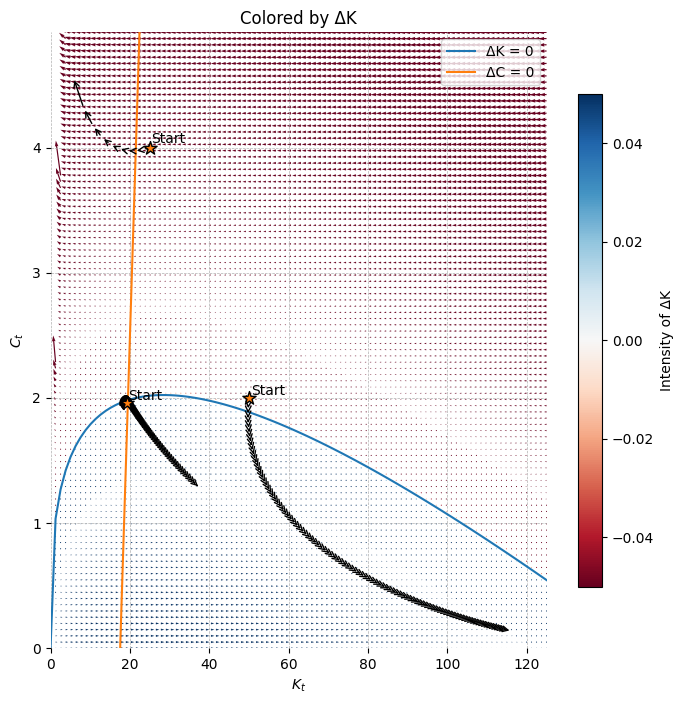

In [12]:
C_ss, K_ss = f_ss(**param_dict)

fig, ax = plot_RBC_phase_diagram(125, param_dict, title='Colored by ΔK', color_using='K')
fig, ax = plot_simulation_in_phase_space(f_transition, trajectory_start={'C_t':4, 'K_t':25}, param_dict=param_dict, fig_ax=(fig, ax))
fig, ax = plot_simulation_in_phase_space(f_transition, trajectory_start={'C_t':2, 'K_t':50}, param_dict=param_dict, fig_ax=(fig, ax))
fig, ax = plot_simulation_in_phase_space(f_transition, trajectory_start={'C_t':C_ss * 0.99, 'K_t':K_ss * 0.99}, param_dict=param_dict, fig_ax=(fig, ax))

## Shooting

Shooting is pretty easy. We seek an initial control, $c_0$, that results in a trajectory ending in a desired terminal state, $K_T$. Make a guess, simulate the system, then update the guess. Following quantecon, we will use the bisection method to pin down the initial condition. To do this, we need to keep track of an upper and lower bound to our guess:

* Initialize the lower bound on C_0 to 0
* Initialize the upper bound of C_0 to output given K_T: f(K_t, alpha).
* Take the midpoint as the initial guess.

Based on the outcome of the simulation, we update one of the boundaries:

* If final captial overshoots the target, consumption was too low. C_0 becomes the lower bound.
* If final capital undershoots the target, consumption was too high. C_0 becomes the upper bound.

In [21]:
def shooting_algorithm(f_transition, c0, k0, target_K, param_dict, T=100, maxiter=1000, tol=1e-8, verbose=True, print_interval=50):
    
    bounds = np.array([0, k0 ** param_dict['alpha']])
    
    for i in range(maxiter):
        traj = simulate_model(f_transition, init_state_dict={'C_t':c0, 'K_t':k0}, param_dict=param_dict, T=T)
        final_K = traj.loc[traj.dropna().index[-1], 'K']
        error = abs(target_K - final_K)
        
        if (i % print_interval) == 0 and i > 0 and verbose: 
            print(f'Loss at iteration {i}: {error:0.6f}', end='\r')
        if error < tol:
            if verbose:
                print(f'Convergence achieved at iteration {i} with loss: {error:0.6f}')
            return traj
        if final_K > target_K:
            bounds[0] = c0
        else:
            bounds[1] = c0
        c0 = bounds.mean()
        
    if verbose:
        print('Maximum iterations exhausted. Algorithm did not converge.')
        return

For any pair of initial and final capital, we can use the shooting algorithm to find an initial consumption level that delivers the final capital.

In [28]:
traj = shooting_algorithm(f_transition, 3, 25, target_K := K_ss, param_dict, T := 250, maxiter=100)

Convergence achieved at iteration 50 with loss: 0.000000


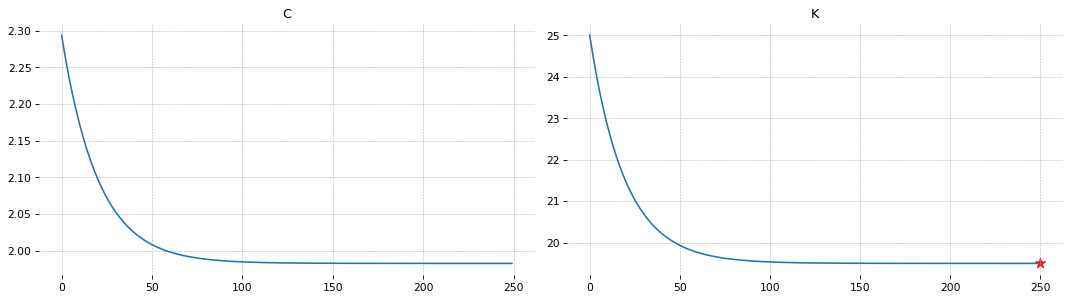

In [29]:
fig, ax = plt.subplots(1, 2)
for axis, var in zip(fig.axes, traj):
    traj[var].plot(ax=axis)
    axis.set_title(var)
    if var == 'K':
        axis.scatter(T, target_K, c='tab:red', marker='*', s=100)
fig.tight_layout()
plt.show()

Finding all such initial consumptions for all initial capitals targeting steady-state capital will give us the saddle path in phase space.

In [42]:
c_saddle = np.zeros(100)
K_grid = np.linspace(1, 100, 100)
for i, K in enumerate(K_grid):
    traj = shooting_algorithm(f_transition, K / 2, K, K_ss, param_dict, T=100, verbose=False)
    c_saddle[i] = traj.loc[0, 'C']


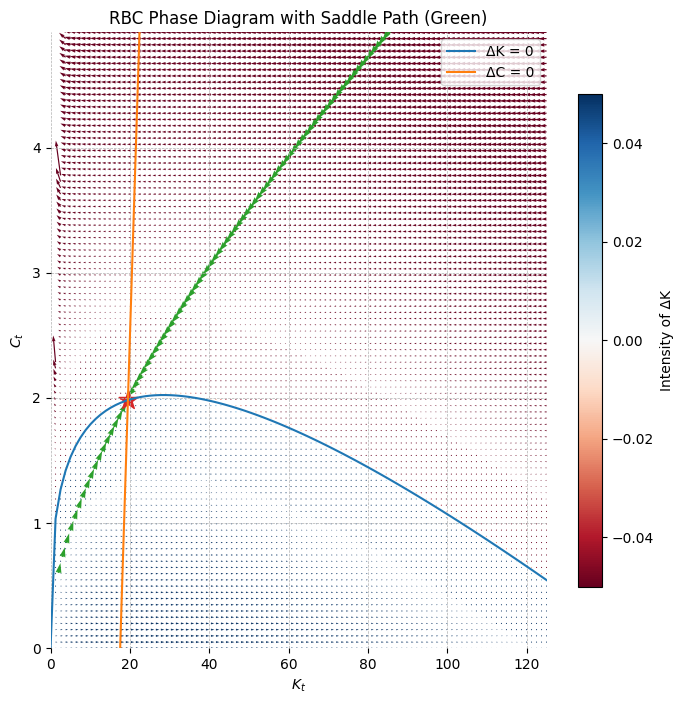

In [57]:
fig, ax = plot_RBC_phase_diagram(125, param_dict, title='RBC Phase Diagram with Saddle Path (Green)', color_using='K')

pos_mask = K_grid < K_ss
ax.quiver(K_grid[pos_mask][1:], c_saddle[pos_mask][1:], 
          np.diff(K_grid[pos_mask]),
          np.diff(c_saddle[pos_mask]),
          angles='xy', scale=50, facecolor='tab:green')
ax.quiver(K_grid[~pos_mask][1:], 
          c_saddle[~pos_mask][1:],
          np.diff(K_grid[~pos_mask][::-1]), 
          np.diff(c_saddle[~pos_mask][::-1]),
          angles='xy', scale=50, facecolor='tab:green')
ax.scatter(K_ss, C_ss, marker='*', color='tab:red', s=200)
plt.show()

### Relaxation 

A more general solution is relaxation. Instead of just thinking about an initial condition, we can think about all the conditions that an ideal transition will demand. This is a system of equations that results from iterating the transition dynamics over and over for T timesteps.

In [71]:
from gEconpy.shared.utilities import step_equation_forward
T = 10
eq_stack = [var - eq for var, eq in step_eqs.items()]
for t in range(1, T):
    eq_stack.append(step_equation_forward(eq_stack[-2]))
    eq_stack.append(step_equation_forward(eq_stack[-2]))

This pile of equations completely describes the trajectory of the system from time 0 to time T. It's actually a system of non-linear equations. The question is how many there are, and how many unknown variables.

In [136]:
from functools import reduce
unknowns = reduce(lambda a, b: a.union(b), [eq.atoms() for eq in eq_stack])
unknowns = [x for x in unknowns if isinstance(x, TimeAwareSymbol)]
unknowns = sorted(unknowns, key=lambda x: (x.time_index, x.base_name))
print(f'Number of equations: {len(eq_stack)}')
print(f'Number of unknowns: {len(unknowns)}')

print(unknowns)

Number of equations: 20
Number of unknowns: 22
[C_t, K_t, C_t+1, K_t+1, C_t+2, K_t+2, C_t+3, K_t+3, C_t+4, K_t+4, C_t+5, K_t+5, C_t+6, K_t+6, C_t+7, K_t+7, C_t+8, K_t+8, C_t+9, K_t+9, C_t+10, K_t+10]


It seems we have more unknowns than equations, but it's no true, because we want to provide an initial and final capital. If we give those, we have a square system, and we can just use an optimizer to find values of $C_t$ to $C_{t+1}$ and $K_{t+1}$ to $K_{t+9}$ that satisfy $K_0$ and $K_{10}$ !

In [143]:
free_vars = [x for x in unknowns if x not in [K.set_t(0), K.set_t(10)]]
f_relaxation = sp.lambdify(free_vars + [K.set_t(0), K.set_t(10)] + [alpha, beta, delta], eq_stack)

# scipy.optimize requires a different signature than is provided by sp.lambdify, so 
# this wrapper is needed (basically to unpack x)
def f_optim_wrapper(x, K0, K10, alpha, beta, delta):
    return f_relaxation(*x, K0, K10, alpha, beta, delta)

In [162]:
# Inital guess is all steady state

x0 = np.array([ss_value_dict[var.base_name] for var in free_vars])
K0 = 30
K_target = K_ss

res = optimize.root(f_optim_wrapper, x0=x0, args=(K0, K_target) + tuple(param_dict.values()))
print('Optimizer converged: ', res['success'])
c_star = np.r_[res.x[0], res.x[1::2]]
k_star = np.r_[K0, res.x[2::2], K_target]

traj = pd.DataFrame(np.c_[c_star[:, None], k_star[:, None]], columns=['C', 'K'])

Optimizer converged:  True


In [163]:
shooting_traj = shooting_algorithm(f_transition, c0=K0/2, k0=K0, target_K=K_target, param_dict=param_dict, T=11)

Convergence achieved at iteration 32 with loss: 0.000000


We can see that both algorithms find the same solution!

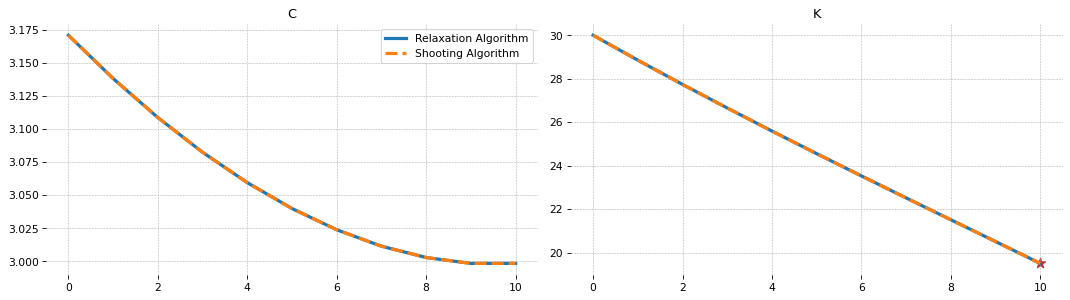

In [164]:
fig, ax = plt.subplots(1, 2)
for axis, var in zip(fig.axes, traj):
    traj[var].plot(ax=axis, lw=3, label='Relaxation Algorithm')
    shooting_traj[var].plot(ax=axis, ls='--', lw=3, label='Shooting Algorithm')
    axis.set_title(var)
    if var == 'K':
        axis.scatter(T, target_K, c='tab:red', marker='*', s=100)
fig.tight_layout()
ax[0].legend()
plt.show()

#### Jacobian Information

One advantage of the relaxation algorithm is that, because we have a system of equations, we can provided an analytical Jacobian to the solver to help it along. This is easy to do using sympy. The structure of the jacobian is block-diagonal, with some small adjustments for the fact that the state variables are missing at the beginning and the end.

In [167]:
jac = sp.SparseMatrix([[eq.diff(x) for x in free_vars] for eq in eq_stack])
jac[:3, :3]

Matrix([
[-alpha*beta*C_t*(1 - alpha)*(-delta*K_t - C_t + K_t + K_t**alpha)**(alpha - 1)/(-delta*K_t - C_t + K_t + K_t**alpha) - beta*(alpha*(-delta*K_t - C_t + K_t + K_t**alpha)**(alpha - 1) - delta + 1),                                                                                                                                                                                                                            1,                                                                                                                                                                             0],
[                                                                                                                                                                                                 1,                                                                                                                                                                                                        

Doing a numerical example (where all the 20 unknowns are equal to their steady-state values), the block-diagonal structure of the Jacobian is much more clear. Also, basically everything is zeros, which is why we asked for a sparse matrix.

In [178]:
f_jac = sp.lambdify(free_vars + [K.set_t(0), K.set_t(10)] + [alpha, beta, delta], jac)
def f_jac_wrapper(x, K0, K10, alpha, beta, delta):
    return f_jac(*x, K0, K10, alpha, beta, delta).todense()

with np.printoptions(linewidth=1000, precision=3, suppress=True):
    print(f_jac_wrapper(x0, K0, K_target, *list(param_dict.values())))

[[-0.99   1.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 1.     0.     1.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.    -1.003  0.003  1.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     1.    -1.01   0.     1.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.    -1.003  0.003  1.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     1.    -1.01   0.     1.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.    -1.003  0.003  1.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]

### Wrapping everything into a nice function

In [190]:
from functools import wraps
def get_unknown_variables(eqs):
    unknowns = reduce(lambda a, b: a.union(b), [eq.atoms() for eq in eqs])
    unknowns = [x for x in unknowns if isinstance(x, TimeAwareSymbol)]
    unknowns = sorted(unknowns, key=lambda x: (x.time_index, x.base_name))
    return unknowns

def scipy_wrapper(f, sparse=False):
    
    @wraps(f)
    def scipy_f(x, K0, K_target, alpha, beta, delta):
        out = f(*x, K0, K_target, alpha, beta, delta)
        if sparse:
            return out.todense()
        return out
        
    return scipy_f

def relaxation_algorithm(transition_equations, T, K0, K_target, param_dict, ss_value_dict, use_jac=False, **optimizer_kwargs):
    eq_stack = [var - eq for var, eq in transition_equations.items()]
    for t in range(1, T):
        eq_stack.append(step_equation_forward(eq_stack[-2]))
        eq_stack.append(step_equation_forward(eq_stack[-2]))
    unknowns = get_unknown_variables(eq_stack)    
    free_vars = [x for x in unknowns if x not in [K.set_t(0), K.set_t(T)]]
    x0 = np.array([ss_value_dict[var.base_name] for var in free_vars])

    jac = sp.SparseMatrix([[eq.diff(x) for x in free_vars] for eq in eq_stack])
    
    f_error = scipy_wrapper(sp.lambdify(free_vars + [K.set_t(0), K.set_t(T)] + [alpha, beta, delta], eq_stack))
    
    f_jac = None
    if use_jac:
        f_jac   = scipy_wrapper(sp.lambdify(free_vars + [K.set_t(0), K.set_t(T)] + [alpha, beta, delta], jac), sparse=True)
    
    res = optimize.root(f_error, x0=x0, jac=f_jac, args=(K0, K_target) + tuple(param_dict.values()), **optimizer_kwargs)
    print('Optimizer converged: ', res['success'])
    c_star = np.r_[res.x[0], res.x[1::2]]
    k_star = np.r_[K0, res.x[2::2], K_target]

    traj = pd.DataFrame(np.c_[c_star[:, None], k_star[:, None]], columns=['C', 'K'])
    
    return traj


One awful thing about this function is that using the jacobian is extremely slow for large T. If T=100, the jacobian has 100 * 100 = 10,000 elements, most of which are just zero anyway. Using the built-in scipy optimizer, we can't take advantage of any of that sparsity, so we have to sit around and wait for matrix inversion. The `lambdify` function is also not built for high performance on large matrices either. So consider this just a demonstration.

In [199]:
traj = relaxation_algorithm(step_eqs, T=100, K0=10, K_target=10, param_dict=param_dict, ss_value_dict=ss_value_dict, use_jac=True)

Optimizer converged:  True


<Axes: >

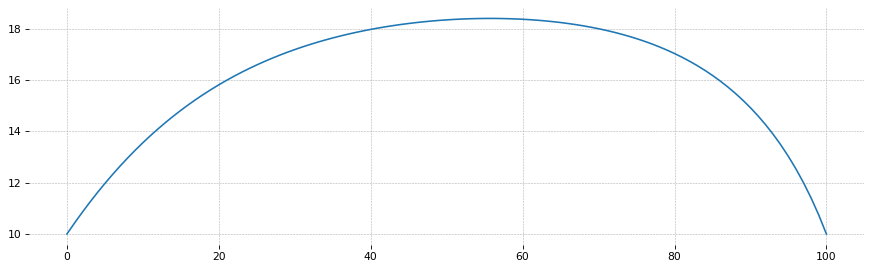

In [200]:
traj['K'].plot()